In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 1] import Libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.metrics import Precision, Recall
from keras.callbacks import ReduceLROnPlateau
import tensorflow.keras.backend as K
import cv2
import os
import numpy as np
from tqdm import tqdm

2024-07-19 09:48:13.826662: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 09:48:13.826749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 09:48:13.828441: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def get_training_data(data_dir):
    data = []
    for label in ['NORMAL', 'PNEUMONIA']:
        path = os.path.join(data_dir, label)
        class_num = 1 if label == 'PNEUMONIA' else 0
        for img in os.listdir(path):
            try:
                if not img.endswith('.DS_Store'): # Skip non-image files
                    img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                    resized_arr = cv2.resize(img_arr, (150, 150)) # Resize image to (150, 150)
                    data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error processing {os.path.join(path, img)}: {str(e)}")
    return np.array(data, dtype=object) # Specify dtype as object

In [4]:
train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

Text(0.5, 1.0, 'NORMAL')

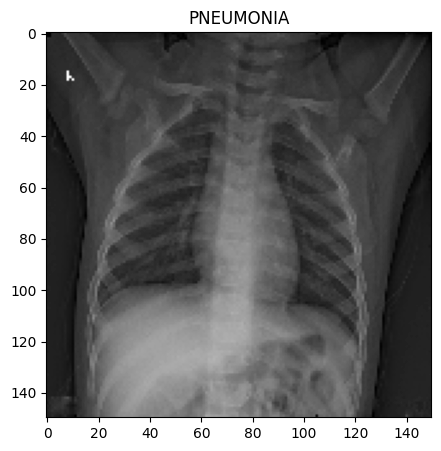

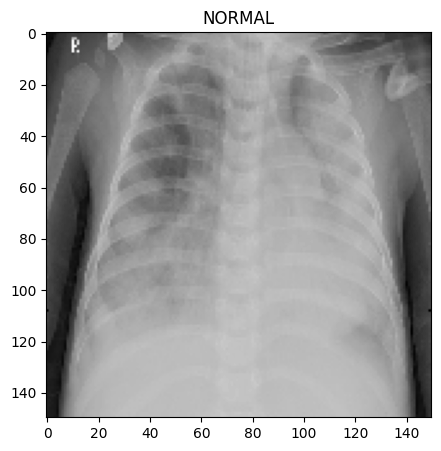

In [5]:
labels = ['PNEUMONIA', 'NORMAL']
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [6]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [7]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [8]:
img_size=150
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [9]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [10]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ["accuracy"])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


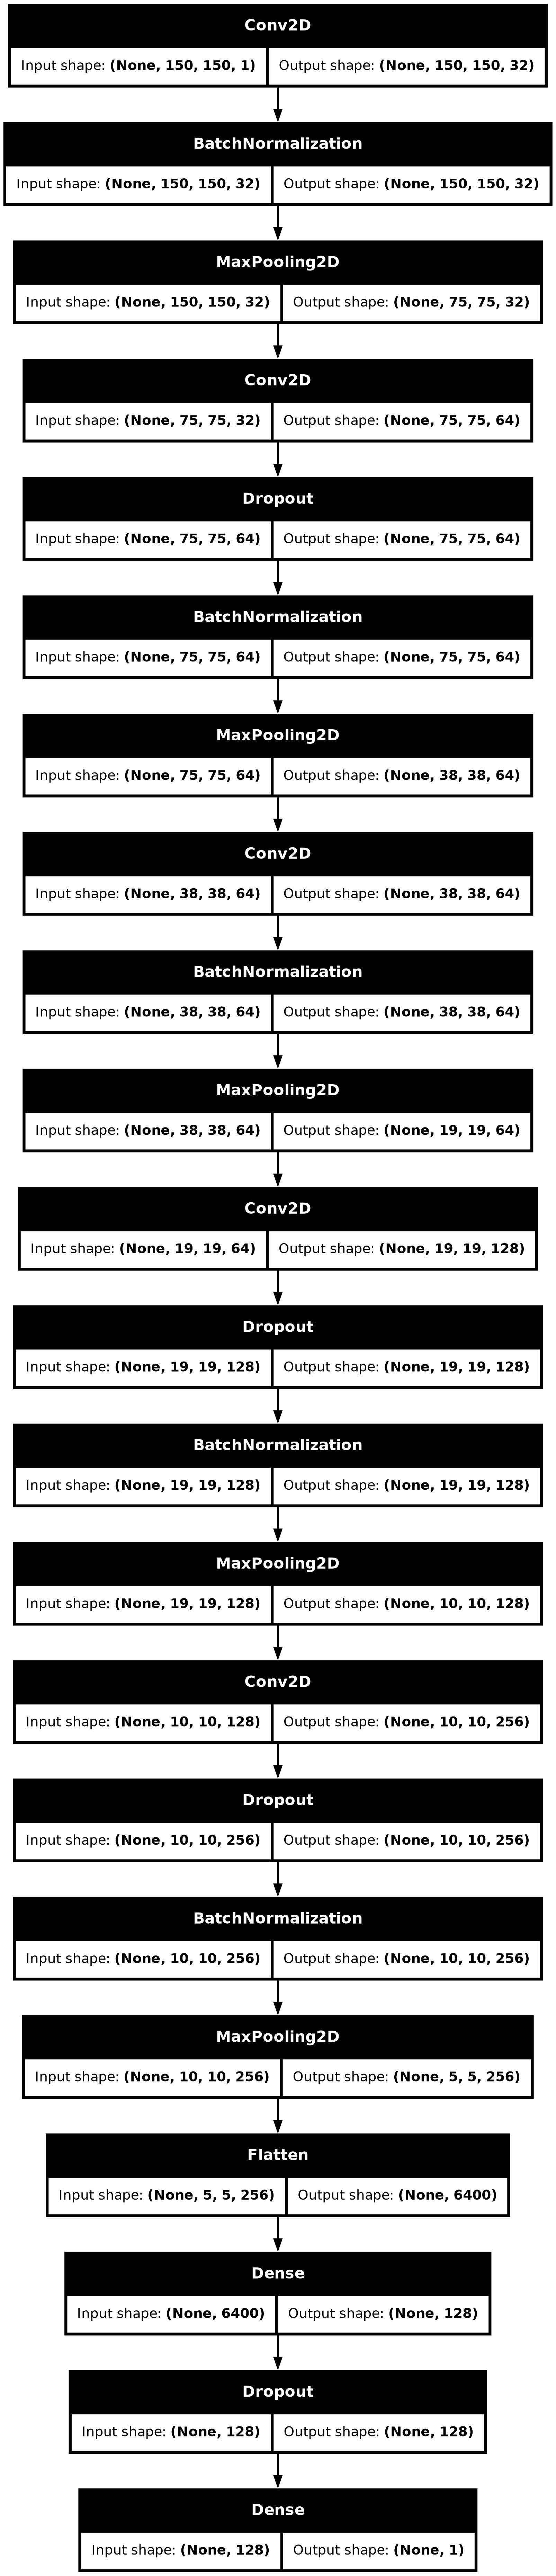

In [11]:
keras.utils.plot_model(model, show_shapes=True)

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [13]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-07-19 09:49:02.317637: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.91263, expected 1.50699
2024-07-19 09:49:02.317690: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.81141, expected 2.40577
2024-07-19 09:49:02.317700: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.48353, expected 2.07789
2024-07-19 09:49:02.317708: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.56582, expected 2.16018
2024-07-19 09:49:02.317716: E external/local_xla/xla/service/gpu/buffer_comparator.cc:11

  4/163 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.4388 - loss: 9.7554 

I0000 00:00:1721382549.376911     530 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7762 - loss: 1.5614

2024-07-19 09:49:18.577620: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.39848, expected 1.01693
2024-07-19 09:49:18.577676: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.61071, expected 1.22915
2024-07-19 09:49:18.577686: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 1.68362, expected 1.30207
2024-07-19 09:49:18.577694: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 1.92843, expected 1.54688
2024-07-19 09:49:18.577704: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 1.3426, expected 0.961047
2024-07-19 09:49:18.577712: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.14728, expected 1.76573
2024-07-19 09:49:18.577719: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.05027, expected 1.66872
2024-07-19 09:49:18.577727: E external/local_xla/xla/se

163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 63ms/step - accuracy: 0.7770 - loss: 1.5501 - val_accuracy: 0.5000 - val_loss: 49.2815 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9045 - loss: 0.2485 - val_accuracy: 0.5000 - val_loss: 56.2480 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.8956 - loss: 0.3101 - val_accuracy: 0.5625 - val_loss: 8.6435 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9263 - loss: 0.2146 - val_accuracy: 0.5000 - val_loss: 58.6543 - learning_rate: 0.0010
Epoch 5/12
162/163 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9356 - loss: 0.1969
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.9356 - loss: 0.1967 - val_accuracy: 0.5000 - val_loss: 22.1621 - learning_rate: 0.0010
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.9444 - loss: 0.1616 -

In [14]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7978 - loss: 0.6203
Loss of the model is -  0.37695547938346863
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7978 - loss: 0.6203
Accuracy of the model is -  87.5 %


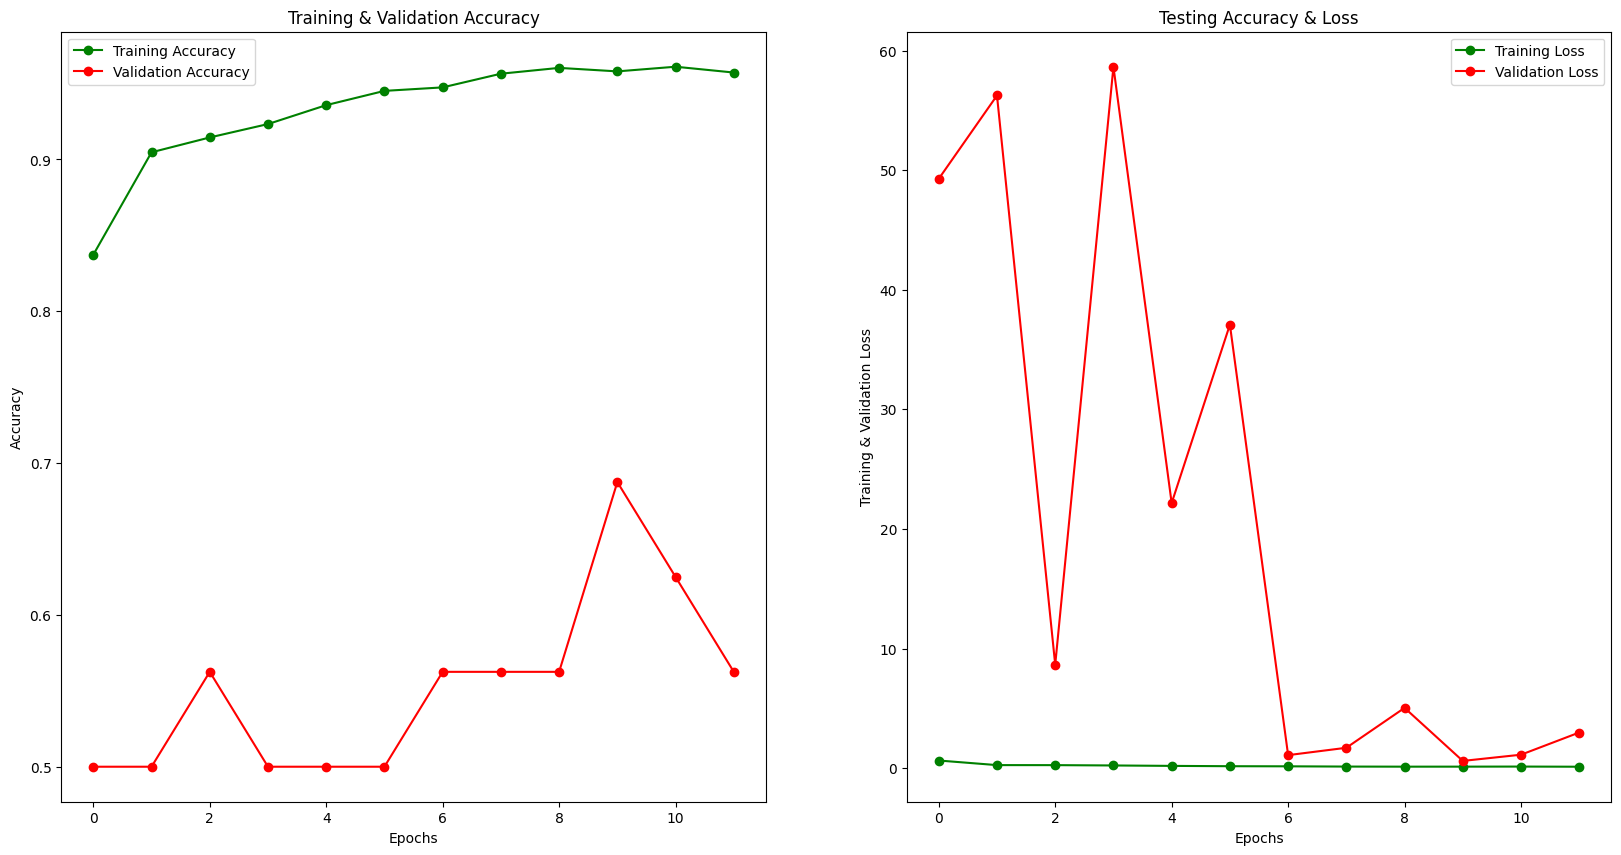

In [15]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [16]:
x_test.shape

(624, 150, 150, 1)

In [17]:
predictions = model.predict(x_test)
index=0 if predictions[0][0]>0.95 else 1

confidence_scores = predictions.reshape(-1)

# Convert continuous predictions to binary based on the 0.95 threshold
binary_predictions = np.where(confidence_scores > 0.95, 1, 0)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, binary_predictions))

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.93      0.78       234
           1       0.94      0.73      0.83       390

    accuracy                           0.81       624
   macro avg       0.81      0.83      0.80       624
weighted avg       0.84      0.81      0.81       624



In [18]:
print(f"Mean: {np.mean(confidence_scores):.4f}")
print(f"Median: {np.median(confidence_scores):.4f}")
print(f"Min: {np.min(confidence_scores):.4f}")
print(f"Max: {np.max(confidence_scores):.4f}")

Mean: 0.7233
Median: 0.9367
Min: 0.0026
Max: 1.0000


In [19]:
import joblib

In [20]:
joblib.dump(model,"model.joblib")

['model.joblib']